Title: Finding Donors for Charity using Machine Learning
Date: 2018-01-07 12:00
Modified: 2018-01-07 12:00
Category: Machine Learning
Tags: Python, Machine Learning, Supervised Learning, Scikit-learn, AdaBoost, SVM, KNN
Slug: finding-donors-for-charityml
Authors: Jonathan Porter
Summary: Comparing and optimizing several classifiers to accurately predict if an individual makes more than $50,000 to identify likely donors for a non-profit organization.
Status: Published

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Let's start by importing the libraries we will use, reading in the data, and taking a look at our dataset.

Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import visualization libraries
import visuals as vs
import seaborn as sns
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

Let's take a look at the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [2]:
# Total number of records
n_records = len(data.index)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = (float(n_greater_50k) / n_records) * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Let's plot a histogram of these two features and see the how the values are distributed.

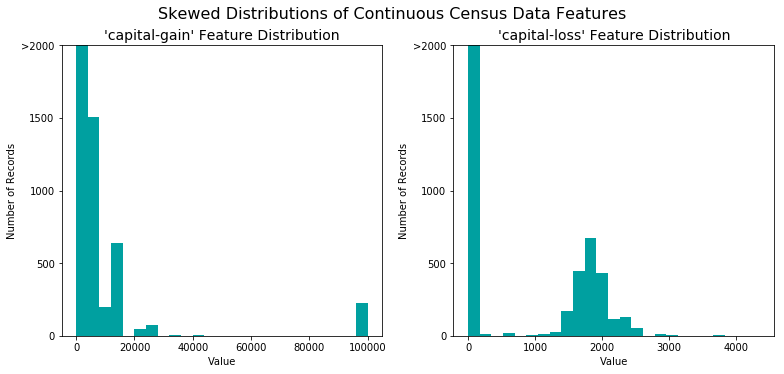

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Next, let's perform the transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

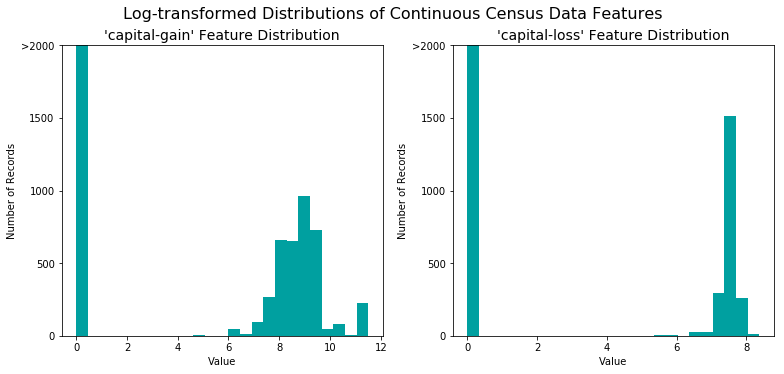

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == ">50K" else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# See the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That being said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset?

The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** Note: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives (TN) or False Negatives (FN) as we are not making any negative ('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision (True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score (True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
TP = float(np.sum(income)) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
                           # encoded to numerical values done in the data preprocessing step.
FP = len(income) - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2) * ((precision * recall) / ((0.5**2 * precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


##  Supervised Learning Models
### Model Application
Now we will choose three supervised learning models that are appropriate for this problem and then test them on the census data.

#### 1. Support Vector Machines (Support Vector Classifier):
* Real world application: Image classification.
* Strengths:
    * It uses a technique called the [kernel trick](http://blog.yhat.com/posts/why-support-vector-machine.html) which can do different complex transformations on your data to help find the optimal boundaries.
    * Works well on [smaller cleaner datasets](https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html).
* Weaknesses:
    * Less effective on noisier datasets with [overlapping classes](https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html).
    * The training time is much longer because it is computationally intensive. 
    * It will perform poorly on large datasets.
* Candidacy: SVMs were chosen for this problem because of their high effectiveness on datasets with high dimensionality. Our dataset grew vastly in terms of features due to our one-hot encoding feature transformation. Also, our dataset isn't that large (<100k records) so it shouldn't be a deterrent.

#### 2. K-Nearest Neighbors (KNeighbors Classifier):
* Real world application: [Recommender Systems](https://en.wikipedia.org/wiki/Recommender_system). If you know a user likes an item, then you can recommend _similar_ items for them.
* Strengths:
    * It is an easy to understand algorithm.
    * It works well with a small number of features (low dimensionality).
* Weaknesses:
    * Lazy learner - all computation is deferred until classification therefore making it computationally intensive for large datasets.
    * If the dataset has many features this algorithm will suffer from the curse of dimensionality because in high demensions, points that may be similar may have very large distances. To solve this, one might try to lower dimensionality or apply feature selection.
* Candidacy: I chose KNN here because it's a simple and reliable classifier for datasets with numerical data that don't have a large sample size. Even though we have a higher amount of features now, I wanted to see how this simple algorithm would compare.

#### 3. Ensemble Methods (AdaBoost):
* Real world application: Image detection. For example, [identifying a basketball player](https://uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf) during a game.
* Strengths:
    * More robust than single estimators because it can have improved generalizability by using [multiple weak classifiers](http://www.nickgillian.com/wiki/pmwiki.php/GRT/AdaBoost).
    * Simple models can be combined to build a complex model which is computationally fast.
* Weaknesses:
    * If our underlying classifier is biased it will lead to a biased boosted model.
* Candidacy: Ensemble methods are considered to be high quality classifiers, and adaboost is the one of most popular boosting algorithms. We also have a class imbalance in our dataset, which boosting might be robust to.

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Model Evaluation
Let’s train and test the models on training sets of different sizes (1%, 10%, and 100% of our data) to see how it affects their runtime and predictive performance.

SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


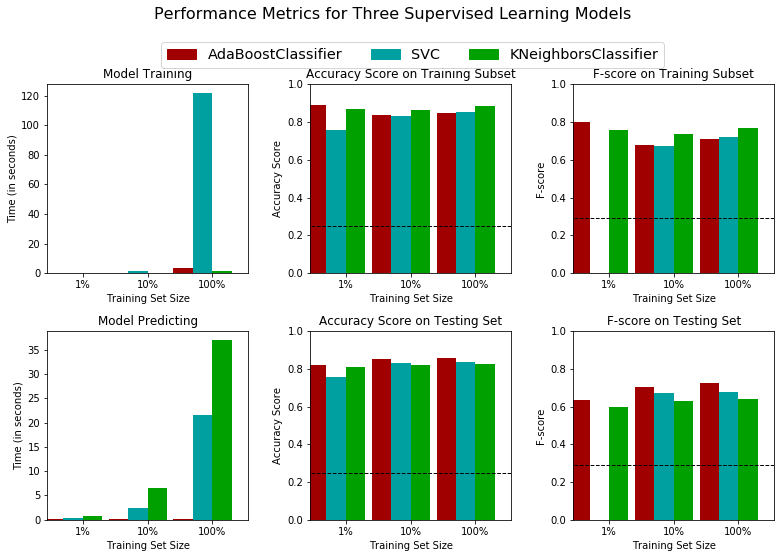

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models
clf_A = SVC(random_state=1)
clf_B = KNeighborsClassifier()
clf_C = AdaBoostClassifier(random_state=1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(X_train)
samples_10 = int(len(X_train)/10)
samples_1 = int(len(X_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [11]:
# Printing out the values
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

AdaBoostClassifier


,1%,10%,100%
acc_test,0.820674,0.849862,0.857601
acc_train,0.893333,0.840000,0.850000
f_test,0.632757,0.701882,0.724551
f_train,0.801282,0.680147,0.711538
pred_time,0.196000,0.183000,0.179000
train_time,0.164000,0.440000,3.259000


SVC


,1%,10%,100%
acc_test,0.756219,0.832615,0.837148
acc_train,0.760000,0.833333,0.853333
f_test,0.000000,0.671256,0.674477
f_train,0.000000,0.671296,0.719697
pred_time,0.281000,2.372000,21.640000
train_time,0.018000,1.272000,121.535000


KNeighborsClassifier


,1%,10%,100%
acc_test,0.807407,0.819569,0.823549
acc_train,0.870000,0.863333,0.883333
f_test,0.600045,0.630839,0.639164
f_train,0.757042,0.736301,0.771605
pred_time,0.799000,6.548000,36.978000
train_time,0.003000,0.024000,1.414000


----
## Improving Results
### Choosing the Best Model

From our initial model evaluation we see that our AdaBoost classifier performed the best in terms of F-score when trained on 100% of the training set. Our AdaBoost Classifier also was the fastest when predicting new data points compared to the SVC and KNN classifiers. It took less than ~1 second whereas the other two algorithms took ~22 seconds or more during prediciton. Another important metric to look at is how long it takes to train our models on the entire training set and we can see here that the AdaBoost Classifier had a very reasonable training time (~3 seconds) albeit not the fastest which was the KNN at around ~1 second. These are good signals that our algorithm should scale if we had more data.

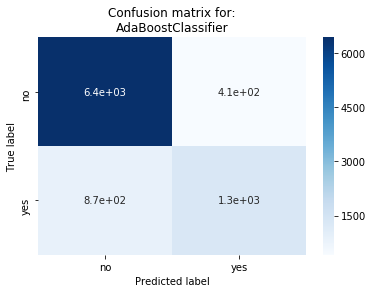

In [12]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix for a model
model = clf_C
cm = confusion_matrix(y_test.values, model.predict(X_test))

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

### How does AdaBoost work?

AdaBoost works by combining multiple weak classifiers to create a strong classifier. A weak classifier being a classifier that simply does better than random guessing but still not necessarily that well overall. But AdaBoost can be applied to any classification algorithm so you could yourself train a bunch of weak classifiers and combine the results - but would it be the same? No, because AdaBoost also handles choosing the training set for each new classifier based on the results of the previous classifier by looking at instances where it predicted poorly and prioritizing the correct prediction of those instances in the next round of training. It also determines how much weight each classifier should be given when they "vote" for the final result. 

[Reference](http://mccormickml.com/2013/12/13/adaboost-tutorial/)

### Optimization: Model Tuning
Using grid search (GridSearchCV) with different parameter/value combinations, we can tune our model for even better results.

For AdaBoost, we’ll tune the n_estimators and learning rate parameters.

In [13]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(random_state=2)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {
    'n_estimators': [50, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nBest Classifier\n------"
print best_clf

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8651
Final F-score on the testing data: 0.7396

Best Classifier
------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=2)


### Final Model Evaluation
#### Results:

|     Metric     |Benchmark Predictor| Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478            | 0.8576            | 0.8651          |
| F-score        | 0.2917            | 0.7246            | 0.7396          |


The optimized model has an accuracy of 0.8651 and an F-score of 0.7396 which is better than the unoptimized model and significantly more so than the benchmark predictor.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Before we see what the top five most predictive features are, we can make an educated guess and later on compare our guesses to the actual features.

In my opinion, these features would be:

1. capital-gain: The higher your captial gain is the more likely it is you had enough money to invest in something in the first place.
2. education-num: Higher education enables people to get better paying jobs.
3. native-country: Some countries may have better opportunities than others.
4. occupation: Some professions have higher salaries than others.
5. age: The older you are the more time you've had to reap the benefits from the above four factors.

### Extracting Feature Importance

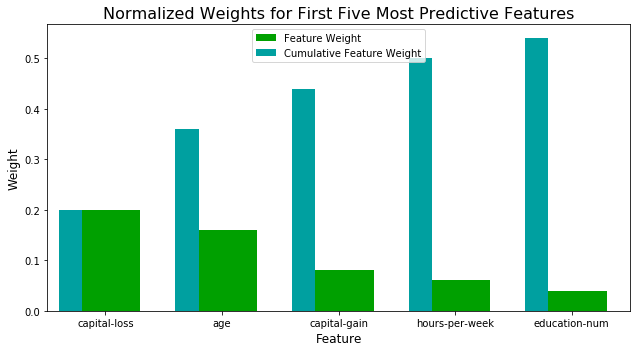

In [14]:
# Using AdaBoostClassifier which was imported earlier which has 'feature_importances_'

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state=3).fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

These five features closely resemble what I had originally predicted. The two features that were different from my prediction were capital-loss and hours-per-week which make sense but I didn't believe they carried as much weight as they do.

**Note** that this is an area where domain knowledge can come into play. For example, knowing what 'capital-gain' means helped me identify that as an important feature.

### Feature Selection
Now that we know what the top five predictive features are, an interesting question we can pose is, how does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn.

Let's use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*.

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8651
F-score on testing data: 0.7396

Final Model trained on reduced data
------
Accuracy on testing data: 0.8385
F-score on testing data: 0.6920


### Effects of Feature Selection

The accuracy and F-score from our model trained on reduced data are only a few percentage points lower than the model we trained on all of the features. Even though the AdaBoost Classifier is very fast I would consider using a reduced dataset if training time was a factor depending on how important those extra percentage points of accuracy and F-score are.